Refrences:

[1] The implementation of the LSTM encoder-decoder with attention layer is inspired from the implementation by Arvin pal, can be found here https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/

[2] Cs224d.stanford.edu, 2020. [Online]. Available: https://cs224d.stanford.edu/reports/lucilley.pdf.

In [1]:
import numpy as np
import pandas as pd 
import re
from tensorflow import keras
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")
import nltk
nltk.download('stopwords')
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from attention import AttentionLayer
from keras.utils.vis_utils import plot_model

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [36]:
data = pd.read_csv("train.csv",encoding='latin1')
data = data.dropna(how='all', axis=1)
data = data[~data['Article'].isnull()]
data = data.reset_index(drop=True)
data

,Unnamed: 0,Article,Summary
0,1364,Kelly Holmes will start 2005 with a series of races in Britain.Holmes will make her first track appearance on home soil since winning double Olympic gold in January's Norwich Union International i...,Holmes will make her first track appearance on home soil since winning double Olympic gold in January's Norwich Union International in Glasgow.The Glasgow meeting will see Holmes compete over 1500...
1,383,"Next has said its annual profit will be ÃÂ£5m lower than previously expected because its end-of-year clearance sale has proved disappointing.""Clearance rates in our end-of-season sale have been b...","Next chief executive Simon Wolfson admitted that festive sales were ""below where we would expect a normal Christmas to be"", but said sales should still top analyst expectations.Overall sales acros..."
2,166,"Shares in Solidere, the Lebanese company founded by assassinated former prime minister Rafik Hariri, fell 15% in renewed trading in Beirut.The real estate firm, which dominates Lebanon's stock exc...","Solidere, in which Mr Hariri was a major shareholder, was the major drag on the index.Shares in Solidere, the Lebanese company founded by assassinated former prime minister Rafik Hariri, fell 15% ..."
3,1506,"Germany coach Jurgen Klinsmann has warned goalkeeper Jens Lehmann he may have to quit Arsenal to keep his World Cup dreams alive.Lehmann is understudy to Oliver Kahn in the German squad, but has l...","Klinsmann added: ""If he is not playing regularly he cannot be Germany's number one keeper, or even number two keeper.Germany coach Jurgen Klinsmann has warned goalkeeper Jens Lehmann he may have t..."
4,1973,"Fast web access is encouraging more people to express themselves online, research suggests.A quarter of broadband users in Britain regularly upload content and have personal sites, according to a ...","More than five million households in the UK have broadband and that number is growing fast.The Demos report looked at the impact of broadband on people's net habits.More significantly, argues the ..."
...,...,...,...
2130,1369,"Last April, Kelly Holmes spoke to the BBC Sport website about her loneliness, her fight to stay fit and her decision not to contest both the 800m and 1500m at the Olympics.It just goes to show eve...","With so much time spent in the spotlight, Holmes has increasingly dropped hints that her ambition on the track has begun to wilt.Four months later, Holmes stormed to double Olympic gold and has si..."
2131,271,The Brazilian stock market has risen to a record high as investors display growing confidence in the durability of the country's economic recovery.The main Bovespa index on the Sao Paolo Stock Exc...,"Investors have praised his handling of the economy as foreign investment has risen, unemployment has fallen and inflation has been brought under control.The Brazilian stock market has risen to a r..."
2132,1248,"He called it his ""masochism strategy"" in the run-up to the Iraq war and now Tony Blair has signed up for another dose of pain.The idea is simple - the prime minister goes head to head with an ofte...",Mr Blair used the tactic before the Iraq war to try to show he really was engaging with public concerns and you can expect to see it much more in the run-up to the election.I was prime minister ...
2133,1505,"Real Madrid are closing in on a ÃÂ£2m deal for Everton's Thomas Gravesen after the Dane's agent travelled to Spain to hold talks about a move.John Sivabaek told BBC Sport: ""I'm here to listen to ...","Real Madrid are closing in on a ÃÂ£2m deal for Everton's Thomas Gravesen after the Dane's agent travelled to Spain to hold talks about a move.The 28-year-old's contract expires in the summer, but..."


In [2]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [3]:
stop_words = set(stopwords.words('english')) 

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [39]:
cleaned_text = []
cleaned_summary = []

a = data['Article']
s = data['Summary']

print(len(a),len(s))

for t in range(len(a)):
    cleaned_text.append(text_cleaner(a[t],0))
    cleaned_summary.append(text_cleaner(s[t],1))

2135 2135


In [40]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

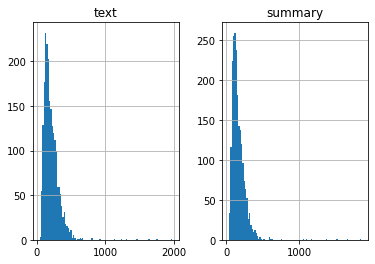

In [41]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 100)
plt.show()

In [42]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split())<=300):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

0.935831381733021


In [14]:
cnt=0
for i in data['cleaned_text']:
    if(len(i.split())<=700):
        cnt=cnt+1
print(cnt/len(data['cleaned_text']))

0.9953161592505855


In [4]:
max_text_len = 700
max_summary_len = 300

In [16]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df = pd.DataFrame({'text':short_text,'summary':short_summary})

In [17]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [18]:
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True)

In [20]:
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

x_tr    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val   =   x_tokenizer.texts_to_sequences(x_val)

x_tr    =   pad_sequences(x_tr,  maxlen=max_text_len, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_text_len, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1

(1798, 700)


In [21]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

y_tr    =   y_tokenizer.texts_to_sequences(y_tr)
y_val   =   y_tokenizer.texts_to_sequences(y_val) 

y_tr    =   pad_sequences(y_tr, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_summary_len, padding='post')

y_voc_size  =   len(y_tokenizer.word_index) +1

In [12]:
from keras import backend as K 
K.clear_session() 
latent_dim = 500 

# Encoder 
encoder_inputs = Input(shape=(max_text_len,)) 
enc_emb = Embedding(x_voc_size, latent_dim,trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 700)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 700, 500)     2822000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 700, 500), ( 2002000     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
_______________________________________________________________________________________

In [13]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

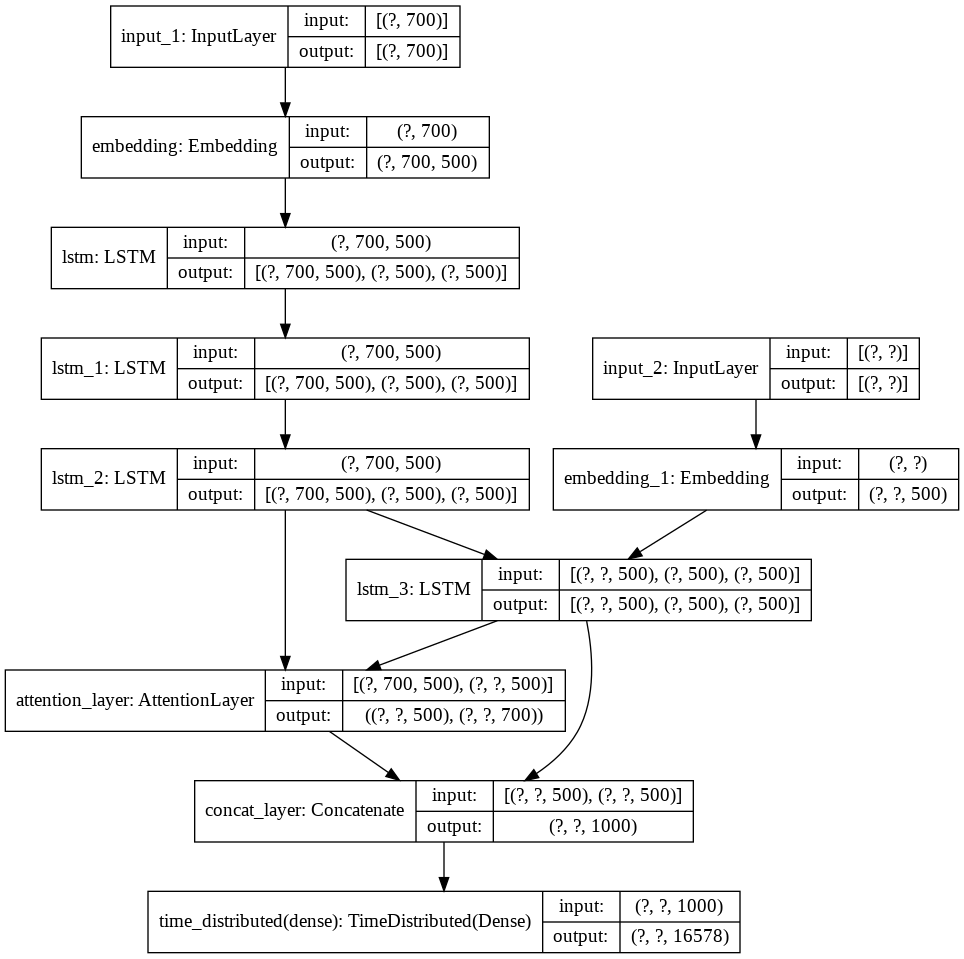

In [23]:
plot_model(model, to_file='model.png', show_shapes=True) 

In [24]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:],
                  epochs=50,
                  callbacks=[es],
                  batch_size=16, 
                  validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/50
113/113 [==============================] - 318s 3s/step - loss: 3.8243 - val_loss: 3.3516
Epoch 2/50
113/113 [==============================] - 336s 3s/step - loss: 3.3969 - val_loss: 3.1225
Epoch 3/50
113/113 [==============================] - 335s 3s/step - loss: 3.1710 - val_loss: 2.9949
Epoch 4/50
113/113 [==============================] - 335s 3s/step - loss: 3.0254 - val_loss: 2.9419
Epoch 5/50
113/113 [==============================] - 336s 3s/step - loss: 2.8989 - val_loss: 2.8968
Epoch 6/50
113/113 [==============================] - 337s 3s/step - loss: 2.7909 - val_loss: 2.8494
Epoch 7/50
113/113 [==============================] - 336s 3s/step - loss: 2.6804 - val_loss: 2.8244
Epoch 8/50
113/113 [==============================] - 335s 3s/step - loss: 2.5733 - val_loss: 2.8115
Epoch 9/50
113/113 [==============================] - 335s 3s/step - loss: 2.4660 - val_loss: 2.7985
Epoch 10/50
113/113 [==============================] - 334s 3s/step - loss: 2.3518 - val_lo

In [25]:
model.save('model_1_1.h5')

In [26]:
!cp /content/model_1_1.h5 drive/MyDrive/DAL/

In [5]:
from keras.models import load_model
# Assuming your model includes instance of an "AttentionLayer" class
model = load_model('drive/MyDrive/DAL/model_1_1.h5', custom_objects={'AttentionLayer': AttentionLayer})

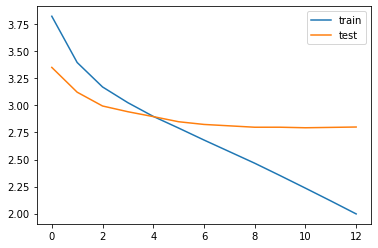

In [27]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [14]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [15]:
target_word_index=y_tokenizer.word_index
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [16]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
for i in range(len(x_tr[:5])):
    print("Review:",seq2text(x_tr[i]))
    print(len(seq2text(x_tr[i]).split(" ")))
    print("Original summary:",seq2summary(y_tr[i]))
    print(len(seq2summary(y_tr[i]).split(" ")))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print(len(decode_sequence(x_tr[i].reshape(1,max_text_len)).split(" ")))
    print("\n")

In [6]:
data = pd.read_csv("test.csv",encoding='latin1')
data = data.dropna(how='all', axis=1)
# data = data[data['Article'].astype(bool)]
data = data[~data['Article'].isnull()]
data = data.reset_index(drop=True)
data

,Unnamed: 0,Article,Summary
0,572,French film A Very Long Engagement has receive...,Last November a court judged the film was too ...
1,2067,"If you have finished Doom 3, Half Life 2 and H...",Released 1 March on PC.Released 11 February on...
2,1566,Manchester City striker Nicolas Anelka has iss...,No-one has come to me and said I would like to...
3,644,The US Vibe awards will be held again next yea...,Rapper Young Buck has been charged after alleg...
4,217,South Africa biggest retail bank Absa has said...,South Africa biggest retail bank Absa has said...
...,...,...,...
85,537,Harry Potter director Alfonso Cuaron has signe...,His first film for Warner Brothers was 1995's ...
86,713,US comedian Bill Cosby will not face charges s...,"Cosby's lawyer, Walter M Phillips Jr, said the..."
87,1370,Jason Gardener fought all the way to the line ...,also set a new championship mark in the men's ...
88,584,Mike Leigh's award-winning abortion drama Vera...,Considine is also nominated for a best support...


In [7]:
cleaned_text = []
cleaned_summary = []

a = data['Article']
s = data['Summary']

for t in range(len(a)):
    cleaned_text.append(text_cleaner(a[t],0))
    cleaned_summary.append(text_cleaner(s[t],1))

data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

In [9]:
data['cleaned_summary'] = data['cleaned_summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [10]:
x_tokenizer = Tokenizer()

x_test = data['cleaned_text']
x_tokenizer.fit_on_texts(list(x_test))

x_test    =   x_tokenizer.texts_to_sequences(x_test)
x_test   =   pad_sequences(x_test,  maxlen=max_text_len, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1

In [11]:
y_tokenizer = Tokenizer()

y_test = data['cleaned_summary']
y_tokenizer.fit_on_texts(list(y_test))

y_test    =   y_tokenizer.texts_to_sequences(y_test)

y_test    =   pad_sequences(y_test, maxlen=max_summary_len, padding='post')

y_voc_size  =   len(y_tokenizer.word_index) +1

In [17]:
final = ""
for i in range(len(x_test)):
    print("Review:",seq2text(x_test[i]))
    pred = decode_sequence(x_test[i].reshape(1,max_text_len))
    pred = " ".join(set(pred.split(" ")))
    final = final + "\n" + pred
    print("Predicted summary:",pred)
    print("\n")

text_file = open("output.txt", "w")
text_file.write(final)
text_file.close()

Review: french film long engagement received nominations france cesar film awards despite recent ruling french enough world war romantic drama starring audrey tautou recently ruled american paris court partially backed warner bros cesar organisers modified rules allow film compete film directed jean pierre jeunet received best actress picture director nominations last november court judged film american compete french film festivals two associations french producers challenged jeunet right french government subsidies warner bros backer ruling meant movie filmed france used french actors technicians eligible compete french prizes alain terzian president cesar organisers academie des arts et techniques du cinema said changes eligibility rules allow films french expression made three months prior court decision films best film category include police drama quai des orfevres arnaud desplechin kings queen abdellatif kechiche esquive france number one film box office chorus best actors danie

KeyError: ignored